# Self Tuning Regulator

In [1]:
## % Imports
import numpy as np
from data_driven_control import RLS_Estimator, TransferFunction
import control as ct
%matplotlib widget
import matplotlib.pyplot as plt
from matrepr import mdisplay, to_latex
from IPython.display import display, Latex, HTML

### System Definition
![Schematic of the controller](strctr.svg)  
System Transfer function is:  
$$G = \frac{B(z)}{A(z)} = \frac{z + 1.2}{z^2 -z +1/4}$$
Desired Transfer Function is:  
$$G_d = \frac{B_d(z)}{A_d(z)} = \frac{b_{d0}z + b_{d1}}{z^2 - 0.7358z + 0.1353}$$
Controller is given through pole placement by:  
$S = s_0 z + s_1$  
$R = z + r_1$  
$T = \beta(z + a_0)$  
$B_d = B\beta$  
where:  
$\beta = \frac{A_d(1)}{B(1)}$  
  
$$
\left(
\begin{array}{ccc}
    1 & b_0 & 0 \\
    a_1 & b_1 & b_0 \\
    a_2 & 0 & b_1
\end{array}
\right)^{-1}
\left(\begin{array}{c}
a_o +a_{d1} - a_1 \\
a_{d1}a_0 + a_{d2} - a_2 \\
a_{d2}a_0
\end{array}\right)
=
\left(\begin{array}{c}
r_1 \\ s_0 \\ s_1
\end{array}\right)
$$

In [2]:
# Real system
G = TransferFunction([1, 1.2], [1, -1, 0.25]) # Unknown in reality
Ad = [1, -0.7358, 0.1353] # Desired transfer poles
# Desired transfer fcn for comparison
Gd = TransferFunction(G.num*(np.sum(Ad)/np.sum(G.num)), Ad)

a0 = -0.5 # Just give it some stable value

def update_controller(A_hat:np.ndarray, B_hat:np.ndarray):
    beta = np.sum(Ad)/np.sum(B_hat)
    LM = np.array([[1,B_hat[0],0],
                   [A_hat[1], B_hat[1], B_hat[0]],
                   [A_hat[2],0,B_hat[1]]], dtype=float)
    RM = np.array([[a0+Ad[1]-A_hat[1]],
                   [Ad[1]*a0+Ad[2]-A_hat[2]],
                   [Ad[2]*a0]], dtype=float)
    r1, s0, s1 = (np.linalg.pinv(LM)@RM).flatten()

    T = np.array([1,a0], dtype=float)*beta
    R = np.array([1, r1], dtype=float)
    S = np.array([s0, s1], dtype=float)
    return T,R,S

display(HTML(r'<h3> System Definitions </h3>'))
display(Latex(r'$G(z) =$ ' + G._repr_latex_()))
display(Latex(r'$G_d(z) =$ ' + Gd._repr_latex_()))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

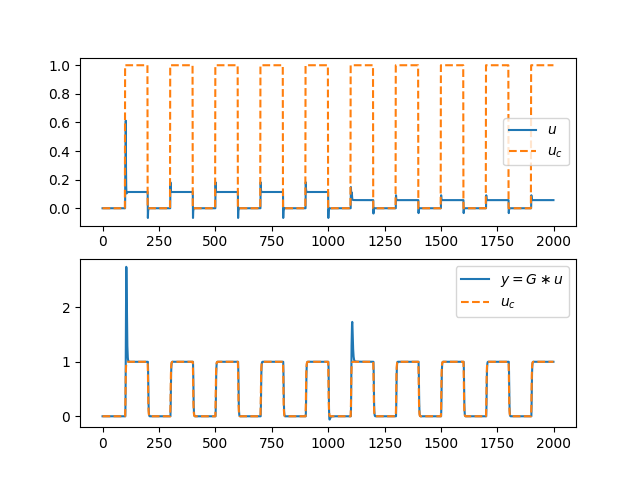

In [3]:
n = 2000 # Nr of sim steps

# Pre allocating arrays
uc = (#np.concat([np.random.uniform(-0.5,0.5,int(n/2)), np.zeros(int(n/2))])
      + np.array([(i // 100 + 2)%2 for i in range(n)], dtype=float) )# Square wave
u = np.zeros_like(uc)
uv = np.zeros_like(uc)
y = np.zeros_like(uc)
yd = np.zeros_like(uc)
e = np.zeros_like(uc)# + np.random.uniform(-0.05, 0.05, n)
v = 0

# Initiating controller and RLS estimator
G = TransferFunction([1, 1.2], [1, -1, 0.25]) # To maintain consistency between runs
Gd.reset()
TR = TransferFunction([1,0],[1,0])
SR = TransferFunction([1,0],[1,0])
RLS = RLS_Estimator([1,0.2],[1,0.1,0.3], ff=0.95)
y[0] = G.update(u[0]) + e[0]
yd[0] = Gd.update(uc[0])
for i in range(n-1):
    # Updating RLS estimate
    Bhat, Ahat = RLS.update(y[i], u[i])
    # Updating Controller from RLS
    T, R, S = update_controller(Ahat, Bhat)
    TR.tf = (T,R)
    SR.tf = (S,R)
    # Calculating next input and advancing the system
    u[i+1] = TR.update(uc[i]) - SR.update(y[i])
    uv[i+1] = u[i+1] + v
    y[i+1] = G.update(uv[i+1]) + e[i+1]

    # Desired system sim for comparison
    yd[i+1] = Gd.update(uc[i+1])

    # Changing the system sumtimes
    if i == int(n/2):
        G = 2*G

fig, ax = plt.subplots(2)
ax[0].plot(u, label='$u$')
ax[0].plot(uc, label='$u_c$', linestyle='--')
ax[0].legend()
ax[1].plot(y, label=r'$y=G\ast u$')
ax[1].plot(yd, label=r'$u_c$', linestyle='--')
ax[1].legend()
plt.show()